In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, finalize_model, predict_model
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
import requests
from datetime import datetime
import logging

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Base API URL
BASE_URL = "https://fantasy.premierleague.com/api"

# Helper function to calculate extra fields
def is_weekend(day):
    return 1 if day.lower() in ["saturday", "sunday"] else 0

# Function to fetch and parse API data
def fetch_api_data(endpoint):
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}")
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to fetch data from {endpoint}: {e}")
        return None

# Fetch static data
logging.info("Fetching bootstrap-static data...")
bootstrap_static = fetch_api_data("bootstrap-static/")
if not bootstrap_static:
    raise RuntimeError("Failed to fetch bootstrap-static data")

# Fetch fixtures data
logging.info("Fetching fixtures data...")
fixtures_data = fetch_api_data("fixtures/")
if not fixtures_data:
    raise RuntimeError("Failed to fetch fixtures data")

# Extract and process general data
players = pd.DataFrame(bootstrap_static['elements'])
teams = pd.DataFrame(bootstrap_static['teams'])
positions = pd.DataFrame(bootstrap_static['element_types'])

# Map team and position IDs to readable names
team_map = teams.set_index('id')['name']
position_map = positions.set_index('id')['singular_name_short']

players['team'] = players['team'].map(team_map)
players['position'] = players['element_type'].map(position_map)
players['full_name'] = players['first_name'] + " " + players['second_name']

# Prepare fixtures DataFrame
fixtures_df = pd.DataFrame(fixtures_data)
fixtures_df = fixtures_df[['id', 'team_h_difficulty', 'team_a_difficulty']]

# Function to process a single player's data
def process_player_history(player_id, players_df, fixtures_df):
    player_data = fetch_api_data(f"element-summary/{player_id}/")
    if not player_data or 'history' not in player_data:
        return []

    history = player_data['history']
    gameweek_entries = []

    for match in history:
        kickoff_datetime = datetime.strptime(match['kickoff_time'], '%Y-%m-%dT%H:%M:%SZ')
        kickoff_day = kickoff_datetime.strftime('%A')
        kickoff_hour = kickoff_datetime.hour

        # Fetch difficulty ratings
        fixture_data = fixtures_df[fixtures_df['id'] == match['fixture']]
        team_h_difficulty = fixture_data['team_h_difficulty'].values[0] if not fixture_data.empty else None
        team_a_difficulty = fixture_data['team_a_difficulty'].values[0] if not fixture_data.empty else None

        # Get player-specific details
        player_row = players_df.loc[players_df['id'] == player_id]
        if player_row.empty:
            continue

        transfers_in = player_row['transfers_in'].values[0]
        transfers_out = player_row['transfers_out'].values[0]
        transfers_balance = transfers_in - transfers_out

        gameweek_entries.append({
            'name': player_row['full_name'].values[0],
            'position': player_row['position'].values[0],
            'team': player_row['team'].values[0],
            'xP': match.get('expected_points', 0),
            'assists': match['assists'],
            'bonus': match['bonus'],
            'bps': match['bps'],
            'clean_sheets': match['clean_sheets'],
            'creativity': match['creativity'],
            'element': player_id,
            'expected_assists': match.get('xA', 0),
            'expected_goal_involvements': match.get('xGI', 0),
            'expected_goals': match.get('xG', 0),
            'expected_goals_conceded': match.get('xGC', 0),
            'fixture': match['fixture'],
            'goals_conceded': match['goals_conceded'],
            'goals_scored': match['goals_scored'],
            'ict_index': match['ict_index'],
            'influence': match['influence'],
            'kickoff_time': kickoff_datetime,
            'minutes': match['minutes'],
            'opponent_team': match['opponent_team'],
            'own_goals': match['own_goals'],
            'penalties_missed': match['penalties_missed'],
            'penalties_saved': match['penalties_saved'],
            'red_cards': match['red_cards'],
            'round': match['round'],
            'saves': match['saves'],
            'selected': player_row['selected_by_percent'].values[0],
            'starts': int(match['minutes'] > 0),
            'team_a_score': match['team_a_score'],
            'team_h_score': match['team_h_score'],
            'threat': match['threat'],
            'total_points': match['total_points'],
            'transfers_balance': transfers_balance,
            'transfers_in': transfers_in,
            'transfers_out': transfers_out,
            'value': player_row['now_cost'].values[0],
            'was_home': match['was_home'],
            'yellow_cards': match['yellow_cards'],
            'GW': match['round'],
            'team_h_difficulty': team_h_difficulty,
            'team_a_difficulty': team_a_difficulty,
            'kickoff_hour': kickoff_hour,
            'kickoff_day': kickoff_day,
            'is_weekend': is_weekend(kickoff_day),
        })
    return gameweek_entries

# Process all players
logging.info("Processing player data...")
all_gameweek_data = []
for player_id in players['id']:
    all_gameweek_data.extend(process_player_history(player_id, players, fixtures_df))

# Convert to DataFrame
data = pd.DataFrame(all_gameweek_data)

# Format columns and ensure correct data types
data['kickoff_time'] = pd.to_datetime(data['kickoff_time'], utc=True)
data['team_h_difficulty'] = data['team_h_difficulty'].astype('category')
data['team_a_difficulty'] = data['team_a_difficulty'].astype('category')
data['ict_index'] = pd.to_numeric(data['ict_index'], errors='coerce')
data['influence'] = pd.to_numeric(data['influence'], errors='coerce')
data['selected'] = pd.to_numeric(data['selected'], errors='coerce')

logging.info("Data processing complete.")

data.head()

2024-12-10 14:12:25,628 - INFO - Fetching bootstrap-static data...
2024-12-10 14:12:25,718 - INFO - Fetching fixtures data...
2024-12-10 14:12:25,760 - INFO - Processing player data...
2024-12-10 14:12:52,394 - INFO - Data processing complete.


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,transfers_out,value,was_home,yellow_cards,GW,team_h_difficulty,team_a_difficulty,kickoff_hour,kickoff_day,is_weekend
0,Fábio Ferreira Vieira,MID,Arsenal,0,0,0,0,0,0.0,1,...,2756,54,True,0,1,2,5,14,Saturday,1
1,Fábio Ferreira Vieira,MID,Arsenal,0,0,0,0,0,0.0,1,...,2756,54,False,0,2,5,4,16,Saturday,1
2,Fábio Ferreira Vieira,MID,Arsenal,0,0,0,0,0,0.0,1,...,2756,54,True,0,3,2,5,11,Saturday,1
3,Fábio Ferreira Vieira,MID,Arsenal,0,0,0,0,0,0.0,1,...,2756,54,False,0,4,5,4,13,Sunday,1
4,Fábio Ferreira Vieira,MID,Arsenal,0,0,0,0,0,0.0,1,...,2756,54,False,0,5,5,5,15,Sunday,1


In [3]:
# Check for missing values
data = data.dropna()

In [4]:
# Quick overview of the dataset
print("Dataset Overview:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9927 entries, 0 to 9926
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   name                        9927 non-null   object             
 1   position                    9927 non-null   object             
 2   team                        9927 non-null   object             
 3   xP                          9927 non-null   int64              
 4   assists                     9927 non-null   int64              
 5   bonus                       9927 non-null   int64              
 6   bps                         9927 non-null   int64              
 7   clean_sheets                9927 non-null   int64              
 8   creativity                  9927 non-null   object             
 9   element                     9927 non-null   int64              
 10  expected_assists            9927 non-null 

In [5]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def preprocess_data(data):
    """
    Preprocess the dataset for analysis and modeling.
    Includes type conversion, feature engineering, and encoding.
    """
    logging.info("Starting data preprocessing...")

    # Ensure numerical columns are in the correct type
    numerical_columns = ['xP', 'total_points', 'transfers_balance', 'value', 'threat', 'creativity']
    for col in numerical_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    logging.info("Converted numerical columns to numeric types.")

    # Convert kickoff_time to datetime and extract temporal features
    data['kickoff_time'] = pd.to_datetime(data['kickoff_time'], errors='coerce')
    data['kickoff_hour'] = data['kickoff_time'].dt.hour
    data['kickoff_day'] = data['kickoff_time'].dt.day_name()
    data['is_weekend'] = (data['kickoff_time'].dt.weekday >= 5).astype(int)
    logging.info("Extracted temporal features from kickoff_time.")

    # Ensure categorical columns are of type 'category'
    categorical_columns = ['team_h_difficulty', 'team_a_difficulty']
    for col in categorical_columns:
        data[col] = data[col].astype('category')
    logging.info("Converted categorical columns to 'category' type.")

    # Drop rows where target column is missing
    original_row_count = data.shape[0]
    data = data.dropna(subset=['total_points'])
    logging.info(f"Dropped rows with missing 'total_points': {original_row_count - data.shape[0]} rows removed.")

    # Encode categorical variables for machine learning models
    data_model = pd.get_dummies(
        data,
        columns=['position', 'team', 'starts', 'team_h_difficulty', 'team_a_difficulty', 'kickoff_day'],
        drop_first=True
    )
    logging.info("Encoded categorical variables using one-hot encoding.")

    # Drop unnecessary columns
    columns_to_drop = ['fixture', 'kickoff_time', 'bps', 'bonus', 'xP']
    data_model = data_model.drop(columns=columns_to_drop, errors='ignore')
    logging.info(f"Dropped unnecessary columns: {columns_to_drop}")

    logging.info("Data preprocessing complete.")
    return data_model

# Apply preprocessing
data_model = preprocess_data(data)

# Display the first few rows of the processed data
data_model.head()

2024-12-10 14:12:52,501 - INFO - Starting data preprocessing...
2024-12-10 14:12:52,508 - INFO - Converted numerical columns to numeric types.
2024-12-10 14:12:52,519 - INFO - Extracted temporal features from kickoff_time.
2024-12-10 14:12:52,520 - INFO - Converted categorical columns to 'category' type.
2024-12-10 14:12:52,524 - INFO - Dropped rows with missing 'total_points': 0 rows removed.
2024-12-10 14:12:52,531 - INFO - Encoded categorical variables using one-hot encoding.
2024-12-10 14:12:52,533 - INFO - Dropped unnecessary columns: ['fixture', 'kickoff_time', 'bps', 'bonus', 'xP']
2024-12-10 14:12:52,533 - INFO - Data preprocessing complete.


,name,assists,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,team_h_difficulty_5,team_a_difficulty_3,team_a_difficulty_4,team_a_difficulty_5,kickoff_day_Monday,kickoff_day_Saturday,kickoff_day_Sunday,kickoff_day_Thursday,kickoff_day_Tuesday,kickoff_day_Wednesday
0,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False
1,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,True,False,False,True,False,False,False,False
2,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False
3,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,True,False,False,False,True,False,False,False
4,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,True,False,False,True,False,False,False


In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def clean_column_names(df):
    """
    Clean column names to ensure compatibility with PyCaret and other libraries.
    """
    logging.info("Cleaning column names...")
    df.columns = (
        df.columns
        .str.replace(' ', '_')
        .str.replace("'", "")
        .str.strip()
        .str.lower()
    )
    logging.info("Column names cleaned.")
    return df

def train_and_predict(data, target_column, session_id=123):
    """
    Set up PyCaret regression, train the best model, and make predictions.
    """
    try:
        # Clean column names
        data = clean_column_names(data)

        # PyCaret setup for regression
        logging.info("Setting up PyCaret regression environment...")
        regression_setup = setup(
            data=data,
            target=target_column,
            session_id=session_id,
            normalize=True,
            normalize_method='robust',  # Handles outliers better
            preprocess=True,
            multicollinearity_threshold=0.85,  # Remove highly correlated features
            fold_strategy='kfold',  # K-Fold cross-validation
            fold=5,
            use_gpu=True  # Leverage GPU if available
        )
        logging.info("PyCaret setup complete.")

        # Compare models and select the best one
        logging.info("Comparing models to select the best one...")
        best_model = compare_models()
        logging.info(f"Best model selected: {best_model}")

        # Train the best model on the full dataset
        logging.info("Finalizing the best model...")
        final_model = finalize_model(best_model)

        # Make predictions for the full dataset
        logging.info("Making predictions...")
        predictions = predict_model(final_model, data)
        logging.info("Predictions completed.")

        return final_model, predictions

    except Exception as e:
        logging.error(f"An error occurred during model training or prediction: {e}")
        raise

# Train and predict
final_model, predictions = train_and_predict(data_model, target_column='total_points')

# Display predictions
predictions.head()

2024-12-10 14:12:52,565 - INFO - Cleaning column names...
2024-12-10 14:12:52,566 - INFO - Column names cleaned.
2024-12-10 14:12:52,566 - INFO - Setting up PyCaret regression environment...
2024-12-10 14:12:54,224 - INFO - HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopp

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopp

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopp

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopp

,Description,Value
0,Session id,123
1,Target,total_points
2,Target type,Regression
3,Original data shape,"(9927, 70)"
4,Transformed data shape,"(9927, 70)"
5,Transformed train set shape,"(6948, 70)"
6,Transformed test set shape,"(2979, 70)"
7,Numeric features,32
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

2024-12-10 14:12:57,709 - INFO - PyCaret setup complete.
2024-12-10 14:12:57,709 - INFO - Comparing models to select the best one...


[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopp

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0933,0.1319,0.3615,0.9757,0.0642,0.0466,0.2960
catboost,CatBoost Regressor,0.1595,0.1663,0.4067,0.9693,0.0887,0.1273,7.7980
xgboost,Extreme Gradient Boosting,0.1187,0.1874,0.4290,0.9658,0.0655,0.0661,0.3480
rf,Random Forest Regressor,0.1084,0.1980,0.4420,0.9638,0.0734,0.0514,0.4060
lightgbm,Light Gradient Boosting Machine,0.1499,0.2578,0.5034,0.9530,0.0972,0.0976,0.5340
gbr,Gradient Boosting Regressor,0.2028,0.2554,0.5044,0.9528,0.1136,0.1567,1.1260
dt,Decision Tree Regressor,0.1193,0.3263,0.5651,0.9406,0.0889,0.0505,0.1140
lr,Linear Regression,0.3303,0.4176,0.6455,0.9222,0.1769,0.2825,0.1020
br,Bayesian Ridge,0.3304,0.4177,0.6456,0.9222,0.1768,0.2830,0.0980
ridge,Ridge Regression,0.3309,0.4193,0.6468,0.9218,0.1770,0.2847,0.0860


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

2024-12-10 14:14:04,953 - INFO - Best model selected: ExtraTreesRegressor(n_jobs=-1, random_state=123)
2024-12-10 14:14:04,953 - INFO - Finalizing the best model...
2024-12-10 14:14:05,527 - INFO - Making predictions...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0000,0.0000,0.0000,1.0000,0.0002,0.0000


2024-12-10 14:14:05,713 - INFO - Predictions completed.


,name,assists,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,team_a_difficulty_4,team_a_difficulty_5,kickoff_day_monday,kickoff_day_saturday,kickoff_day_sunday,kickoff_day_thursday,kickoff_day_tuesday,kickoff_day_wednesday,total_points,prediction_label
0,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,0,0.0
1,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,True,False,False,False,False,0,0.0
2,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,0,0.0
3,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,False,True,False,False,False,0,0.0
4,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,False,True,False,False,False,0,0.0


2024-12-10 14:14:05,764 - INFO - Calculating feature importances...
2024-12-10 14:14:05,796 - INFO - Feature importances calculated. Displaying the table:


,Feature,Importance
10,goals_scored,0.256067
12,influence,0.149328
13,minutes,0.137156
2,clean_sheets,0.119539
11,ict_index,0.083844
56,starts_1,0.079663
1,assists,0.070421
36,position_mid,0.027452
34,position_fwd,0.017577
30,yellow_cards,0.010412


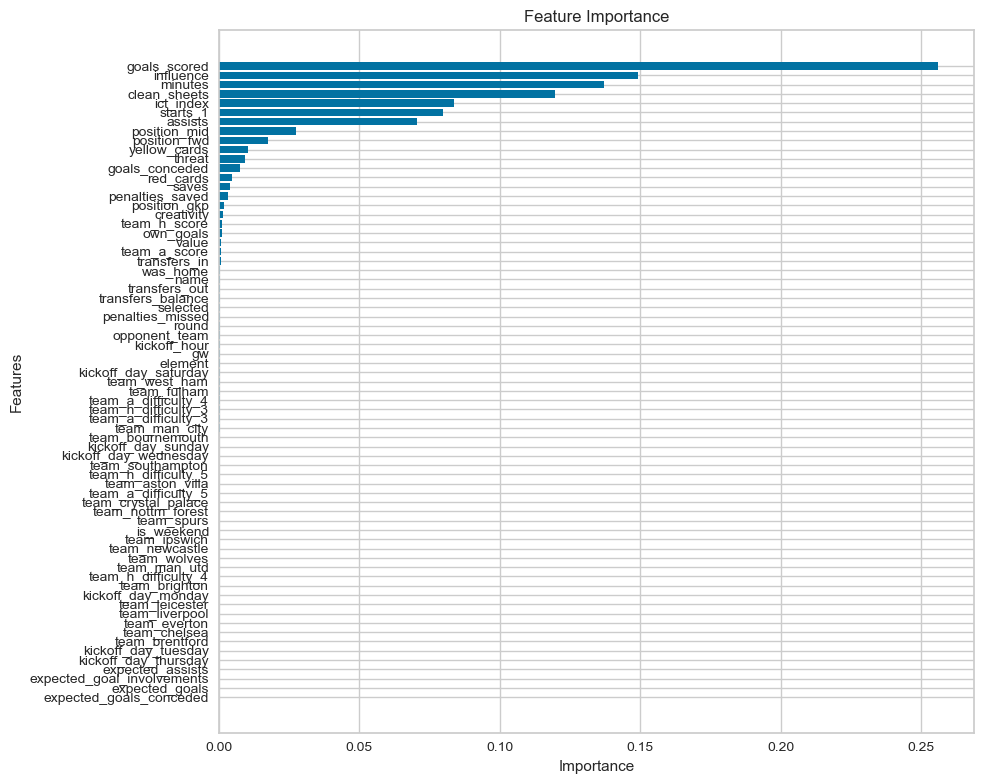

In [7]:
def display_feature_importance(model, data, target_column):
    """
    Display and visualize feature importance for tree-based models.
    
    Parameters:
    - model: Trained model
    - data: Dataset used for training (excluding target column)
    - target_column: Name of the target column
    """
    if hasattr(model, 'feature_importances_'):
        logging.info("Calculating feature importances...")
        
        # Extract feature importance
        feature_importance = pd.DataFrame({
            'Feature': data.drop(columns=[target_column]).columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        # Display feature importance as a table
        pd.set_option('display.max_rows', None)  # Show all rows
        logging.info("Feature importances calculated. Displaying the table:")
        display(feature_importance)

        # Plot feature importance
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
        plt.gca().invert_yaxis()  # Highest importance on top
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        return feature_importance
    else:
        logging.warning("The selected model does not support feature importances.")
        print("The selected model does not support feature importances.")
        return None

# Call the function
feature_importance_df = display_feature_importance(final_model, data_model, target_column='total_points')

In [8]:
# Function to calculate weighted average
def weighted_avg(series, weight_decay=0.8):
    """
    Calculate the weighted average for a pandas Series.
    
    Parameters:
    - series: pandas Series to compute the weighted average for.
    - weight_decay: The decay factor for weighting (default=0.8).
    
    Returns:
    - Weighted average value.
    """
    weights = [(weight_decay ** i) for i in range(len(series))]
    weights.reverse()  # Reverse so recent weeks have higher weights
    return (series * weights).sum() / sum(weights)

# 1. Numeric Columns for Rolling Averages
numeric_columns = [
    'goals_scored', 'assists', 'clean_sheets', 'creativity', 
    'expected_assists', 'expected_goal_involvements', 'expected_goals', 
    'expected_goals_conceded', 'goals_conceded', 'ict_index', 
    'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score', 
    'threat', 'total_points', 'transfers_balance', 'transfers_in', 
    'transfers_out', 'value', 'yellow_cards'
]

# 2. Determine the Last 5 Gameweeks
if 'gw' not in data_model.columns:
    raise KeyError("'gw' column is missing in the data_model DataFrame.")
    
max_gw = data_model['gw'].max()
print(f"Max GW: {max_gw}")
last_5_gws = list(range(max_gw - 4, max_gw + 1))

# 3. Filter Data for the Last 5 Gameweeks
last_5_gws_data = data_model[data_model['gw'].isin(last_5_gws)]
print(f"Filtered data for the last 5 GWs: {last_5_gws_data.shape[0]} rows.")

# 4. Calculate Weighted Rolling Averages
rolling_avg_weighted = last_5_gws_data.groupby('name')[numeric_columns].apply(
    lambda df: df.apply(weighted_avg, weight_decay=0.8)
).reset_index()

# 5. Prepare the Template for the Next Gameweek
next_gw = max_gw + 1
latest_data_per_player = data_model.sort_values(by=['name', 'gw']).groupby('name').last().reset_index()
gw_template = latest_data_per_player.copy()
gw_template['gw'] = next_gw

# 6. Map Team Difficulties
# Convert 'fixtures' to DataFrame if it is a list
if isinstance(fixtures_data, list):
    print("Converting fixtures from list to DataFrame...")
    fixtures = pd.DataFrame(fixtures_data)

# Check if 'event' column exists
if 'event' not in fixtures.columns:
    raise KeyError("The 'event' column is missing in the fixtures data.")

# Filter for the next gameweek
next_gw_fixtures = fixtures[fixtures['event'] == next_gw]

# Extract relevant columns for difficulty mapping
team_difficulty = next_gw_fixtures[['team_h', 'team_h_difficulty', 'team_a', 'team_a_difficulty']]

# Create Difficulty Mappings
team_h_difficulty_map = team_difficulty.set_index('team_h')['team_h_difficulty'].to_dict()
team_a_difficulty_map = team_difficulty.set_index('team_a')['team_a_difficulty'].to_dict()

# Map Difficulties to the Template
gw_template['team_h_difficulty'] = gw_template['opponent_team'].map(team_h_difficulty_map)
gw_template['team_a_difficulty'] = gw_template['opponent_team'].map(team_a_difficulty_map)

# Fill Missing Difficulties with Default Values
default_difficulty = 3  # Logical default value or average
gw_template['team_h_difficulty'] = gw_template['team_h_difficulty'].fillna(default_difficulty).astype('category')
gw_template['team_a_difficulty'] = gw_template['team_a_difficulty'].fillna(default_difficulty).astype('category')

# 7. Fill Missing Rolling Averages
# Ensure missing values are filled with the player's last recorded values
filled_rolling_avg_weighted = rolling_avg_weighted.set_index('name')
for column in numeric_columns:
    filled_rolling_avg_weighted[column] = filled_rolling_avg_weighted[column].fillna(
        last_5_gws_data.sort_values(by=['name', 'gw']).groupby('name')[column].last()
    )

filled_rolling_avg_weighted.reset_index(inplace=True)

# 8. Merge Rolling Averages into the Template
fpl_input = gw_template.drop(columns=numeric_columns, errors='ignore').merge(
    filled_rolling_avg_weighted, on='name', how='left'
)

# Final Output
print(f"Prepared FPL input for GW {next_gw}:")
fpl_input.head()

Max GW: 15
Filtered data for the last 5 GWs: 3375 rows.
Converting fixtures from list to DataFrame...
Prepared FPL input for GW 16:


,name,element,opponent_team,round,was_home,gw,kickoff_hour,is_weekend,position_fwd,position_gkp,...,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards
0,Aaron Cresswell,517,20,15,True,16,20,0,False,False,...,1.4,1.792004,1.689672,0.000000,0.297477,-93396.0,81410.0,174806.0,40.0,0.000000
1,Aaron Hickey,93,15,15,True,16,15,1,False,False,...,0.0,1.267016,3.030938,0.000000,0.000000,-2224.0,420.0,2644.0,43.0,0.000000
2,Aaron Ramsdale,14,2,15,False,16,15,1,False,True,...,1.4,1.837220,1.274155,0.000000,0.000000,30141.0,257308.0,227167.0,44.0,0.121847
3,Aaron Wan-Bissaka,388,20,15,True,16,20,0,False,False,...,5.9,1.792004,1.689672,8.752975,4.990957,408750.0,593789.0,185039.0,46.0,0.000000
4,Abdoulaye Doucouré,217,20,14,True,16,19,0,False,False,...,0.2,0.000000,2.439024,2.875339,2.728997,-33044.0,17071.0,50115.0,51.0,0.000000


In [9]:
# Set up logging for better debugging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def predict_for_next_week(model, input_data):
    """
    Generate predictions for the next gameweek.
    
    Parameters:
    - model: Trained PyCaret model.
    - input_data: DataFrame containing input features for prediction.
    
    Returns:
    - predictions: DataFrame with predictions for the next gameweek.
    """
    try:
        logging.info("Starting predictions for the next gameweek...")
        # Ensure input data is not empty
        if input_data.empty:
            raise ValueError("Input data for predictions is empty.")
        
        # Run predictions using PyCaret's predict_model
        predictions = predict_model(model, input_data)
        logging.info("Predictions successfully generated.")
        
        # Display the first few rows of predictions
        logging.info("Sample predictions:")
        logging.info(predictions.head())

        return predictions

    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        raise

# Generate predictions for the next gameweek
Predictions_new_week = predict_for_next_week(final_model, fpl_input)

# Display sample predictions
Predictions_new_week.head()

2024-12-10 14:14:08,700 - INFO - Starting predictions for the next gameweek...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2082,0.1174,0.3426,0.9598,0.1579,0.4019


2024-12-10 14:14:08,849 - INFO - Predictions successfully generated.
2024-12-10 14:14:08,849 - INFO - Sample predictions:
2024-12-10 14:14:08,850 - INFO -                  name  element  opponent_team  round  was_home  gw  \
0     Aaron Cresswell      517             20     15      True  16   
1        Aaron Hickey       93             15     15      True  16   
2      Aaron Ramsdale       14              2     15     False  16   
3   Aaron Wan-Bissaka      388             20     15      True  16   
4  Abdoulaye Doucouré      217             20     14      True  16   

   kickoff_hour  is_weekend  position_fwd  position_gkp  ...  team_a_score  \
0            20           0         False         False  ...      1.792004   
1            15           1         False         False  ...      1.267016   
2            15           1         False          True  ...      1.837220   
3            20           0         False         False  ...      1.792004   
4            19           0       

,name,element,opponent_team,round,was_home,gw,kickoff_hour,is_weekend,position_fwd,position_gkp,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,yellow_cards,total_points,prediction_label
0,Aaron Cresswell,517,20,15,True,16,20,0,False,False,...,1.792004,1.689672,0.000000,-93396.0,81410.0,174806.0,40.0,0.000000,0.297477,0.99
1,Aaron Hickey,93,15,15,True,16,15,1,False,False,...,1.267016,3.030938,0.000000,-2224.0,420.0,2644.0,43.0,0.000000,0.000000,0.00
2,Aaron Ramsdale,14,2,15,False,16,15,1,False,True,...,1.837220,1.274155,0.000000,30141.0,257308.0,227167.0,44.0,0.121847,0.000000,-0.06
3,Aaron Wan-Bissaka,388,20,15,True,16,20,0,False,False,...,1.792004,1.689672,8.752975,408750.0,593789.0,185039.0,46.0,0.000000,4.990957,4.73
4,Abdoulaye Doucouré,217,20,14,True,16,19,0,False,False,...,0.000000,2.439024,2.875339,-33044.0,17071.0,50115.0,51.0,0.000000,2.728997,2.69


In [10]:
def enrich_predictions(predictions, data, data_model):
    """
    Enrich predictions with position, team, value, and Points Per Million (PPM).
    
    Parameters:
    - predictions: DataFrame with predictions (Predictions_new_week).
    - data: Original DataFrame with player information.
    - data_model: Processed DataFrame with gameweek data.
    
    Returns:
    - merged_predictions: Enriched DataFrame with additional insights.
    """
    # Step 1: Extract unique player data (name, position, team)
    unique_data = data[['name', 'position', 'team']].drop_duplicates(subset='name')

    # Step 2: Get the last known value for each player
    last_known_values = data_model.groupby('name').last().reset_index()[['name', 'value']]

    # Step 3: Merge position, team, and last known value into predictions
    enriched_predictions = (
        predictions
        .merge(unique_data, on='name', how='left')  # Add position and team
        .merge(
            last_known_values.rename(columns={'value': 'last_known_value'}),  # Rename to avoid conflicts
            on='name',
            how='left'
        )
    )

    # Step 4: Fill missing 'value' with the last known value
    enriched_predictions['value'] = enriched_predictions['value'].fillna(
        enriched_predictions['last_known_value']
    )

    # Step 5: Drop helper columns
    enriched_predictions.drop(columns=['last_known_value'], inplace=True)

    # Step 6: Calculate Points per Million (PPM)
    enriched_predictions['PPM'] = enriched_predictions['prediction_label'] / enriched_predictions['value']

    # Step 7: Sort by PPM (optional)
    enriched_predictions = enriched_predictions.sort_values(by='PPM', ascending=False)

    # Step 8: Keep only required columns
    enriched_predictions = enriched_predictions[['name', 'prediction_label', 'position', 'team', 'value', 'PPM']]

    # Rename 'Label' for clarity
    enriched_predictions.rename(columns={'prediction_label': 'predicted_points'}, inplace=True)

    return enriched_predictions


# Apply the function
final_predictions = enrich_predictions(Predictions_new_week, data, data_model)

# Display final predictions
final_predictions.head()

,name,predicted_points,position,team,value,PPM
188,Enzo Fernández,8.05,MID,Chelsea,50.0,0.161000
381,Kevin Schade,7.58,MID,Brentford,51.0,0.148627
54,Ashley Young,6.80,DEF,Everton,46.0,0.147826
660,Vitalii Mykolenko,6.01,DEF,Everton,43.0,0.139767
15,Alex Iwobi,6.99,MID,Fulham,57.0,0.122632


In [11]:
def calculate_ppm_and_recommend_players(predictions, top_n=10, output_file=None):
    """
    Calculate Points per Million (PPM) and recommend top players per position.

    Parameters:
    - predictions: DataFrame containing player predictions.
    - top_n: Number of top players to recommend per position.
    - output_file: Optional file path to save recommendations as a CSV.

    Returns:
    - top_players: DataFrame with top recommended players sorted by position and PPM.
    """
    # Step 1: Calculate Points per Million (PPM)
    predictions['PPM'] = predictions['predicted_points'] / (predictions['value'] / 10)

    # Step 2: Select top N players per position based on prediction_label
    top_players = (
        predictions.groupby('position', group_keys=False)
        .apply(lambda group: group.nlargest(top_n, 'predicted_points'))
    )

    # Step 3: Sort recommendations by position and PPM
    top_players = top_players.sort_values(by=['position', 'PPM'], ascending=[True, False])

    # Step 4: Save recommendations to a CSV if output_file is provided
    if output_file:
        top_players.to_csv(output_file, index=False)

    return top_players


# Apply the function to get recommendations
top_players = calculate_ppm_and_recommend_players(
    final_predictions, 
    top_n=10, 
    output_file='top_player_recommendations_with_ppm.csv'
)

# Display recommendations
top_players

,name,predicted_points,position,team,value,PPM
54,Ashley Young,6.80,DEF,Everton,46.0,1.478261
660,Vitalii Mykolenko,6.01,DEF,Everton,43.0,1.397674
145,Daniel Muñoz,5.73,DEF,Crystal Palace,47.0,1.219149
675,William Saliba,7.22,DEF,Arsenal,62.0,1.164516
297,James Tarkowski,5.47,DEF,Everton,48.0,1.139583
304,Jarrad Branthwaite,4.97,DEF,Everton,48.0,1.035417
3,Aaron Wan-Bissaka,4.73,DEF,West Ham,46.0,1.028261
477,Maxence Lacroix,4.34,DEF,Crystal Palace,45.0,0.964444
487,Milos Kerkez,4.21,DEF,Bournemouth,46.0,0.915217
361,Jurriën Timber,5.00,DEF,Arsenal,56.0,0.892857


In [12]:
def select_fpl_team(players_df, constraints, budget, output_file=None):
    """
    Select the optimal Fantasy Premier League team based on constraints and budget.

    Parameters:
    - players_df: DataFrame with player data including 'position', 'value', and 'prediction_label'.
    - constraints: Dictionary specifying max players per position (e.g., {"GKP": 2, "DEF": 5}).
    - budget: Total budget for the team in million units.
    - output_file: Optional file path to save the selected team as a CSV.

    Returns:
    - selected_team: DataFrame with the selected best team.
    """
    # Step 1: Prepare data for optimization
    players_df = players_df.copy()
    players_df['cost'] = players_df['value'] / 10  # Convert value to cost in million units

    # Objective function: Maximize predicted points (negated for minimization)
    c = -players_df['predicted_points'].values

    # Step 2: Constraints
    A = []  # Coefficient matrix for inequalities
    b = []  # Right-hand side values

    # Budget constraint
    A.append(players_df['cost'].values)
    b.append(budget)

    # Position constraints
    for pos, max_players in constraints.items():
        A.append((players_df['position'] == pos).astype(int).values)
        b.append(max_players)

    # Bounds: Each player can either be selected (1) or not (0)
    bounds = [(0, 1) for _ in range(len(players_df))]

    # Step 3: Solve the optimization problem
    try:
        result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

        if result.success:
            # Add selection status back to the DataFrame
            players_df['selected'] = result.x.round().astype(int)

            # Filter for selected players
            selected_team = players_df[players_df['selected'] == 1]

            # Save the selected team to a CSV if an output file is specified
            if output_file:
                selected_team.to_csv(output_file, index=False)

            return selected_team
        else:
            raise ValueError("Optimization failed. Check constraints or data validity.")

    except Exception as e:
        raise RuntimeError(f"An error occurred during optimization: {e}")


# Define constraints and budget
constraints = {
    "GKP": 2,  # Max 2 Goalkeepers
    "DEF": 5,  # Max 5 Defenders
    "MID": 5,  # Max 5 Midfielders
    "FWD": 3,  # Max 3 Forwards
}
budget = 100  # Budget in million units

# Call the function with top_players DataFrame
best_team_final = select_fpl_team(
    players_df=top_players,
    constraints=constraints,
    budget=budget,
    output_file='best_team_final.csv'  # Optional: Save the results to a CSV
)

# Display the best team
best_team_final

,name,predicted_points,position,team,value,PPM,cost,selected
54,Ashley Young,6.80,DEF,Everton,46.0,1.478261,4.6,1
660,Vitalii Mykolenko,6.01,DEF,Everton,43.0,1.397674,4.3,1
145,Daniel Muñoz,5.73,DEF,Crystal Palace,47.0,1.219149,4.7,1
675,William Saliba,7.22,DEF,Arsenal,62.0,1.164516,6.2,1
297,James Tarkowski,5.47,DEF,Everton,48.0,1.139583,4.8,1
299,Jamie Vardy,6.08,FWD,Leicester,55.0,1.105455,5.5,1
683,Yoane Wissa,5.73,FWD,Brentford,62.0,0.924194,6.2,1
21,Alexander Isak,6.41,FWD,Newcastle,86.0,0.745349,8.6,1
338,Jordan Pickford,5.48,GKP,Everton,49.0,1.118367,4.9,1
102,Caoimhin Kelleher,4.77,GKP,Liverpool,46.0,1.036957,4.6,1


In [13]:
best_team_final['predicted_points'].sum()

108.10000000000001

In [14]:
best_team_final['cost'].sum()

97.4